# 0. Описание задачи

Дан датасет «Melbourne Housing Snapshot», содержащий информацию о 13 580 объектах недвижимости в Мельбурне. Для каждого объекта известны такие характеристики, как количество комнат, ванных комнат и спален, адрес, статус продажи (например, продан, не продан, снят с торгов и т.д.), тип недвижимости (дом, квартира, таунхаус), агент по недвижимости, дата продажи, расстояние до центра города, регион, район, количество объектов в районе, число парковочных мест, площадь участка и здания, административный округ, почтовый индекс, географические координаты и год постройки.

Классической задачей для этого датасета является задача регрессии - предсказание цены квартиры, однако можно рассмотреть и задачу классификации - продана квартира или нет.

# 1. Просмотр датасета

Загружаем необходимые для работы библиотеки

In [1]:
!pip install kagglehub
!pip install pandas
!pip install seaborn

In [2]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 

Выгружаем датасет с сайта kaggle

In [3]:
path = kagglehub.dataset_download("dansbecker/melbourne-housing-snapshot")
csv_file = "melb_data.csv"
df = pd.read_csv(os.path.join(path, csv_file))

Посмотрим на размер данных.

In [4]:
df.shape

(13580, 21)

Получили 13580 объектов и 21 признак для кажного из них.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

У нас есть 8 признаков типа object. До разделения данных на тестовую и обучающую выборки допустимо привести тип данных признака Date(дата) к типу дата-время.

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [7]:
df['Date'].dtype

dtype('<M8[ns]')

In [8]:
df['Address'].head()

0        85 Turner St
1     25 Bloomburg St
2        5 Charles St
3    40 Federation La
4         55a Park St
Name: Address, dtype: object

Из адреса выделим только тип улицы - например, street, avenue и тд, так как номер дома и сама улица - слишком уникальные признаки, это может лишь ухудшить обучение модели. Ну и так как это действие никак не опирается на весь датасет, утечка данных здесь не страшна.

In [9]:
parts = df['Address'].str.split()
df['house_number'] = parts.str[0]
df['street_type'] = parts.str[-1]
df['street_name'] = parts.str[1:-1].str.join(' ')
df = df.drop(columns=['Address'])

In [10]:
df = df.drop(columns=['street_name','house_number'])

In [11]:
df['street_type'].unique()

array(['St', 'La', 'Rd', 'Gr', 'Ct', 'Dr', 'Pde', 'Pl', 'Hwy', 'N',
       'Parade', 'Tce', 'Bvd', 'Boulevard', 'Highway', 'Cl', 'Athol', 'S',
       'Grove', 'Cct', 'Avenue', 'Righi', 'Esp', 'W', 'Crescent', 'Cir',
       'Crossway', 'Grange', 'Sq', 'Res', 'Esplanade', 'Strand', 'Cove',
       'Mews', 'Crofts', 'Qy', 'Glade', 'Nook', 'Gdns', 'Victoria',
       'Fairway', 'Terrace', 'Ridge', 'Loop', 'East', 'Dell', 'Eyrie',
       'Grn', 'Gra', 'Grand', 'Summit', 'Cr', 'Av', 'Wy', 'Hts',
       'Outlook', 'E', 'Woodland', 'Ave', 'Corso'], dtype=object)

В колонке street_type некоторые значения признаков разные, но имеется в виду одно и то же. Объединим эти случаи.

In [12]:
mapping = {
    #Проспект
    'Av': 'Avenue',
    'Ave': 'Avenue',

    #Роща
    'Gr': 'Grove',
    'Gra': 'Grove',

    #Стороны света
    'N': 'North',
    'S': 'South',
    'W': 'West',
    'E': 'East',

    #Шоссе
    'Hwy': 'Highway',

    #Бульвар
    'Bvd': 'Boulevard',

    #Набережная
    'Esp': 'Esplanade',

    #Парк
    'Pde': 'Parade',
}


df['street_type'] = df['street_type'].replace(mapping)

In [13]:
sold_methods = {'S', 'SP', 'SA'}

df['is_sold'] = df['Method'].isin(sold_methods).astype(int)

In [14]:
df=df.drop('Method', axis=1)

# 2. Разделение данных на обучающую и тестовую выборки

In [15]:
X = df.drop(['is_sold'], axis=1)
y = df['is_sold']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(10864, 2716)

# 3. Визуализиция данных и вычисление основных характеристик

Для object признаков посмотрим количество уникальных значений и частоту встечаемости.

In [17]:
X_train['Suburb'].unique().size

306

In [18]:
counts = X_train['Suburb'].value_counts()
print(counts.tail(250))

Suburb
Heidelberg Heights    67
North Melbourne       66
Ormond                64
Heidelberg West       62
Altona                57
                      ..
Bacchus Marsh          1
Bullengarook           1
Officer                1
Montrose               1
Hurstbridge            1
Name: count, Length: 250, dtype: int64


Для колонки Suburb(район) целых 306 уникальных значений, из которых некоторые встречаются редко. Объединим такие значения в один тип "other" для обучающей выборки и те же самые обозначим как "other" и в тестовой, а также те категории, которых нет в обучающей выборке. Сделать это нужно, так как признак категориальный и, если в тестовой выборке встретится элемент, который не имеет своей кодировки, то он либо будет отмечен как нулевой и не даст прибавки к обучению при OHE, либо при других кодерах могут возникнуть более сложные проблемы. Однако решение нужно принимать только на основе обучающей выборки, чтобы не произошло утечки данных.

In [19]:
threshold = 60
value_counts = X_train['Suburb'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['Suburb'] = X_train['Suburb'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['Suburb'] = X_test['Suburb'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [20]:
X_train['Suburb'].unique().size

61

Уникальных значений стало меньше, повторим то же самое для других признаков типа object с большим числом уникальных признаком и редкой встечаемостью

In [21]:
X_train['SellerG'].unique().size

249

In [22]:
counts = X_train['SellerG'].value_counts()
print(counts.tail(220))

SellerG
Chisholm         61
RW               56
O'Brien          52
Rendina          50
HAR              46
                 ..
LLC               1
PRD               1
Homes             1
PRDNationwide     1
Prowse            1
Name: count, Length: 220, dtype: int64


In [23]:
threshold = 30
value_counts = X_train['SellerG'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['SellerG'] = X_train['SellerG'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['SellerG'] = X_test['SellerG'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [24]:
X_train['SellerG'].unique().size

48

In [25]:
X_train['CouncilArea'].unique().size

34

In [26]:
threshold = 50
value_counts = X_train['CouncilArea'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['CouncilArea'] = X_train['CouncilArea'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['CouncilArea'] = X_test['CouncilArea'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [27]:
X_train['CouncilArea'].unique().size

25

In [28]:
X_train['Regionname'].unique().size

8

In [29]:
counts = X_train['Regionname'].value_counts()
print(counts)

Regionname
Southern Metropolitan         3758
Northern Metropolitan         3119
Western Metropolitan          2354
Eastern Metropolitan          1169
South-Eastern Metropolitan     366
Eastern Victoria                37
Northern Victoria               34
Western Victoria                27
Name: count, dtype: int64


In [30]:
threshold = 40
value_counts = X_train['Regionname'].value_counts()
frequent_values = value_counts[value_counts >= threshold].index
allowed_values = set(frequent_values)

X_train['Regionname'] = X_train['Regionname'].apply(lambda x: 'Other' if x not in allowed_values else x)

X_test['Regionname'] = X_test['Regionname'].apply(lambda x: 'Other' if x not in allowed_values else x)

In [31]:
X_train['Regionname'].unique().size

6

In [32]:
X_train['street_type'].unique().size

46

In [33]:
counts = X_train['street_type'].value_counts()
print(counts)

street_type
St           6389
Rd           2258
Ct            490
Dr            363
Avenue        308
Grove         249
Parade        176
Pl            133
Cr            119
Cl             79
La             56
Boulevard      54
Tce            39
Wy             31
Highway        19
Cct            19
Sq              9
Esplanade       7
Crescent        7
Strand          6
Cir             5
North           5
Gdns            4
Mews            4
Fairway         4
Grn             4
Righi           3
South           2
Crossway        2
Crofts          2
Victoria        2
Ridge           2
Athol           1
Eyrie           1
East            1
Glade           1
Dell            1
Qy              1
Res             1
West            1
Loop            1
Summit          1
Corso           1
Nook            1
Hts             1
Cove            1
Name: count, dtype: int64


In [34]:
threshold1 = 100
value_counts1 = X_train['street_type'].value_counts()
frequent_values1 = value_counts1[value_counts1 >= threshold].index
allowed_values1 = set(frequent_values1)

X_train['street_type'] = X_train['street_type'].apply(lambda x: 'Other' if x not in allowed_values1 else x)

X_test['street_type'] = X_test['street_type'].apply(lambda x: 'Other' if x not in allowed_values1 else x)

In [35]:
X_train['street_type'].unique()

array(['St', 'Rd', 'Dr', 'Other', 'Cr', 'La', 'Avenue', 'Cl', 'Boulevard',
       'Ct', 'Grove', 'Pl', 'Parade'], dtype=object)

In [36]:
X_train['Type'].unique().size

3

Так как у признака Type мало уникальных значений и редких среди них нет, то никакие из них объединять не будем. Однако проверим, совпадают ли множества этих признаков для обущающей и тестовой выборок (то есть нет ли в тестовой выборке того, чего не было в обучающей).

In [37]:
print(X_train['Type'].unique(), X_test['Type'].unique())

['h' 'u' 't'] ['h' 'u' 't']


Переведем тип object в category

In [38]:
X_train['Suburb'] = X_train['Suburb'].astype('category')
X_test['Suburb']  = X_test['Suburb'].astype('category')

X_train['street_type'] = X_train['street_type'].astype('category')
X_test['street_type']  = X_test['street_type'].astype('category')

X_train['SellerG'] = X_train['SellerG'].astype('category')
X_test['SellerG']  = X_test['SellerG'].astype('category')

X_train['CouncilArea'] = X_train['CouncilArea'].astype('category')
X_test['CouncilArea']  = X_test['CouncilArea'].astype('category')

X_train['Regionname'] = X_train['Regionname'].astype('category')
X_test['Regionname']  = X_test['Regionname'].astype('category')

X_train['Type'] = X_train['Type'].astype('category')
X_test['Type']  = X_test['Type'].astype('category')

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 12796 to 7270
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Suburb         10864 non-null  category      
 1   Rooms          10864 non-null  int64         
 2   Type           10864 non-null  category      
 3   Price          10864 non-null  float64       
 4   SellerG        10864 non-null  category      
 5   Date           10864 non-null  datetime64[ns]
 6   Distance       10864 non-null  float64       
 7   Postcode       10864 non-null  float64       
 8   Bedroom2       10864 non-null  float64       
 9   Bathroom       10864 non-null  float64       
 10  Car            10814 non-null  float64       
 11  Landsize       10864 non-null  float64       
 12  BuildingArea   5735 non-null   float64       
 13  YearBuilt      6578 non-null   float64       
 14  CouncilArea    10864 non-null  category      
 15  Lattitude      10864 

Перейдем к визуализации данных

In [40]:
X_train.describe()

,Rooms,Price,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,10864.000000,1.086400e+04,10864,10864.000000,10864.000000,10864.00000,10864.000000,10814.000000,10864.000000,5735.000000,6578.000000,10864.000000,10864.000000,10864.000000
mean,2.936027,1.074965e+06,2017-01-29 01:58:45.773195776,10.098794,3105.375460,2.91366,1.534978,1.607361,524.160254,153.999485,1965.104287,-37.809202,144.994875,7463.120582
min,1.000000,8.500000e+04,2016-01-28 00:00:00,0.000000,3000.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.182550,144.431810,249.000000
25%,2.000000,6.500000e+05,2016-09-10 00:00:00,6.100000,3046.000000,2.00000,1.000000,1.000000,175.000000,92.000000,1940.000000,-37.856200,144.929685,4385.000000
50%,3.000000,9.050000e+05,2017-03-04 00:00:00,9.200000,3084.000000,3.00000,1.000000,2.000000,435.000000,126.000000,1970.000000,-37.802400,144.999845,6567.000000
75%,3.000000,1.328000e+06,2017-06-24 00:00:00,13.000000,3147.000000,3.00000,2.000000,2.000000,650.250000,175.000000,2000.000000,-37.757000,145.057700,10331.000000
max,10.000000,9.000000e+06,2017-09-23 00:00:00,48.100000,3977.000000,20.00000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000
std,0.958138,6.415543e+05,NaN,5.887936,91.576894,0.97057,0.689922,0.962386,1380.498149,601.697183,36.374270,0.078999,0.103943,4379.160271


Получили информацию о числовых признаках. Видим, что для BuildingArea, Car и YearBuilt есть пропущенные значения в обучающей выборке. Посмотрим и для категориальных

In [41]:
X_train.describe(include=['category'])

,Suburb,Type,SellerG,CouncilArea,Regionname,street_type
count,10864,10864,10864,10864,10864,10864
unique,61,3,48,25,6,13
top,Other,h,Nelson,Other,Southern Metropolitan,St
freq,4160,7532,1247,1255,3758,6389


In [42]:
X_test.describe(include=['category'])

,Suburb,Type,SellerG,CouncilArea,Regionname,street_type
count,2716,2716,2716,2716,2716,2716
unique,61,3,48,25,6,13
top,Other,h,Nelson,Other,Southern Metropolitan,St
freq,1086,1917,318,328,937,1615


<Axes: xlabel='Rooms', ylabel='is_sold'>

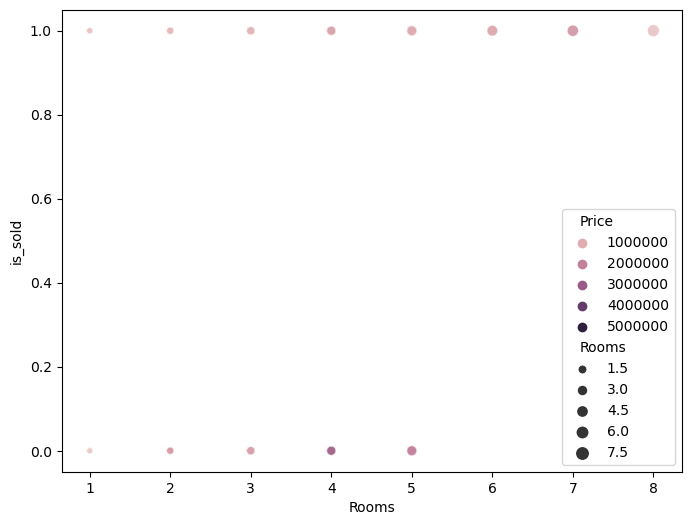

In [43]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(X_train.shape[0]), size=2000, replace=False)
plt.figure(figsize = (8, 6))
sns.scatterplot(x='Rooms', y=y_train, size='Rooms', hue='Price', data=X_train.iloc[random_subset], alpha=0.7)

Выведем матрицу корреляции для количественных признаков. Перед этим приводим все числовые признаки к типу float, потому что данные еще не очищались от пропущенных значений и матрица корреляции будет строится с NaN только если все числовые признаки типа float. Также объединим X_train с y_train, чтобы посмотреть на зависимость цены от остальных признаков.

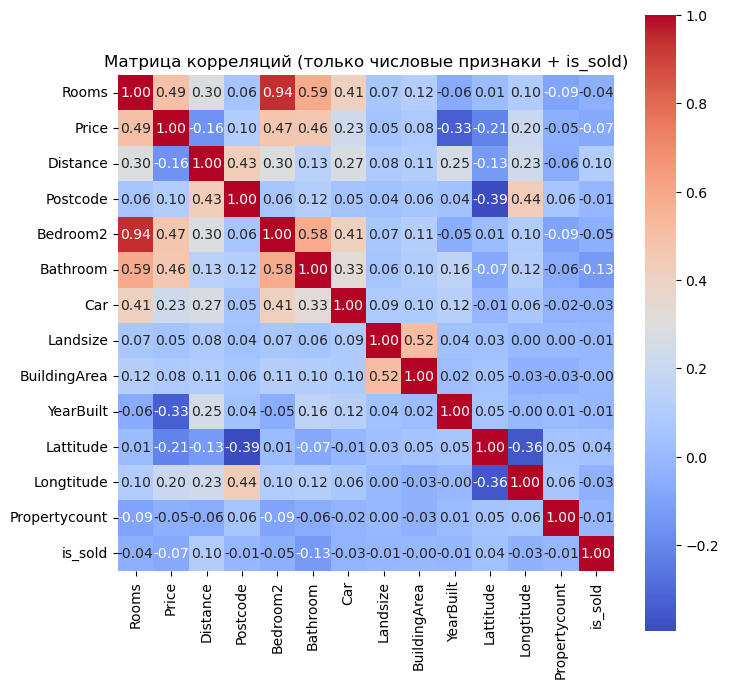

In [44]:
train_df = X_train.copy()
train_df['is_sold'] = y_train
numeric_df = train_df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки + is_sold)')
plt.show()

Видим, что количество комнат очень сильно коррелирует с количеством спален и ванных комнат, которые также коррелируют между собой. Наблюдается также небольшая зависимость почтового индекса от расстояния до центра и от географическогой долготы(при это с широтой корреляция нулевая, из чего можно сделать вывод, даже не смотря на карту Мельбурна, что город располагается растянут по одной широте). Площадь жилья коррелирует с размерами участка. Цена ожидаемо зависит от количества комнат, при этом она очень слабо зависит от года постройки.

Выведем коэффициенты корреляции больше 0.5

In [45]:
corr_mat > 0.5

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,is_sold
Rooms,True,False,False,False,True,True,False,False,False,False,False,False,False,False
Price,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Distance,False,False,True,False,False,False,False,False,False,False,False,False,False,False
Postcode,False,False,False,True,False,False,False,False,False,False,False,False,False,False
Bedroom2,True,False,False,False,True,True,False,False,False,False,False,False,False,False
Bathroom,True,False,False,False,True,True,False,False,False,False,False,False,False,False
Car,False,False,False,False,False,False,True,False,False,False,False,False,False,False
Landsize,False,False,False,False,False,False,False,True,True,False,False,False,False,False
BuildingArea,False,False,False,False,False,False,False,True,True,False,False,False,False,False
YearBuilt,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [46]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending=False)

Rooms     Bedroom2        0.940314
          Bathroom        0.591405
Bedroom2  Bathroom        0.582317
Landsize  BuildingArea    0.516363
dtype: float64

Уберем столбец Bedroom2, а Rooms и Bathroom объединим

In [47]:
X_train = X_train.assign(TotalRooms = X_train['Rooms'] + X_train['Bathroom'])
X_test = X_test.assign(TotalRooms = X_test['Rooms'] + X_test['Bathroom'])

In [48]:
X_train = X_train.drop('Bedroom2', axis=1)
X_test = X_test.drop('Bedroom2', axis=1)
X_train = X_train.drop('Rooms', axis=1)
X_test = X_test.drop('Rooms', axis=1)
X_train = X_train.drop('Bathroom', axis=1)
X_test = X_test.drop('Bathroom', axis=1)

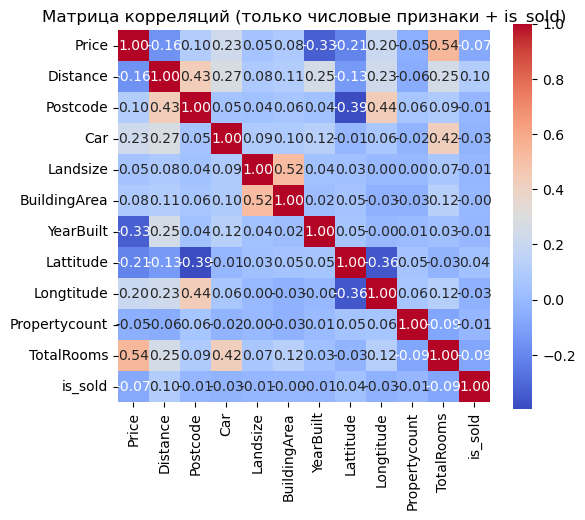

In [49]:
train_df = X_train.copy()
train_df['is_sold'] = y_train
numeric_df = train_df.select_dtypes(include=['number'])
numeric_df = numeric_df.astype('float64')


corr_mat = numeric_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Матрица корреляций (только числовые признаки + is_sold)')
plt.show()

Цена ожидаемо зависит от количества комнат, как и площади строения и территории. Можно объединить LandSize и BuildingArea в один признак

In [50]:
X_train = X_train.assign(TotalArea = X_train['Landsize'] + X_train['BuildingArea'])
X_test = X_test.assign(TotalArea = X_test['Landsize'] + X_test['BuildingArea'])
X_train = X_train.drop('BuildingArea', axis=1)
X_test = X_test.drop('BuildingArea', axis=1)
X_train = X_train.drop('Landsize', axis=1)
X_test = X_test.drop('Landsize', axis=1)

Для обнаружения выбросов удобно использовать бокс-диаграмму.

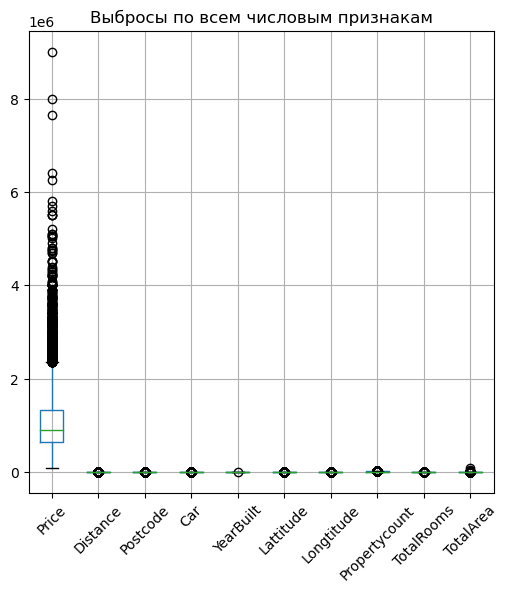

In [51]:
numeric_cols = X_train.select_dtypes(include=['number']).columns

plt.figure(figsize=(6, 6))
X_train[numeric_cols].boxplot()
plt.title('Выбросы по всем числовым признакам')
plt.xticks(rotation=45)
plt.show()

Самые большие выбросы у цены, посмотрим, сколько значений превышают квантили 0.005 и 0.995

In [52]:
rows = X_train[(X_train['Price'] < X_train['Price'].quantile(0.005)) | (X_train['Price'] > X_train['Price'].quantile(0.995))]
print(rows.shape)

(108, 17)


108 строк - это немного, их можно удалить, посмотрим на другие выбросы

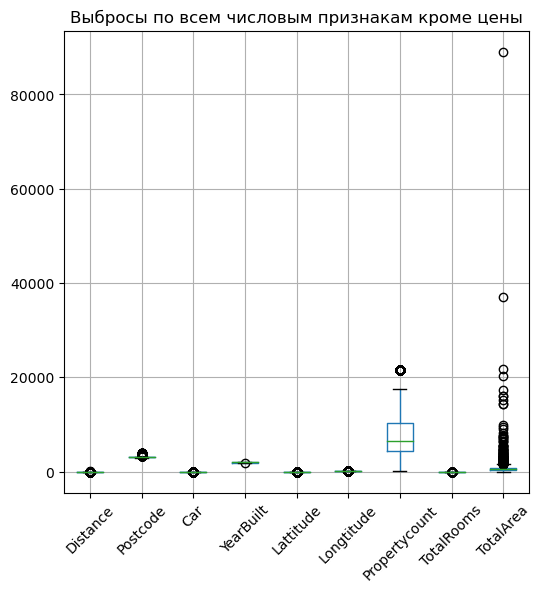

In [53]:
numeric_cols = X_train.select_dtypes(include=['number']).columns
numeric_cols_no_price = numeric_cols.drop('Price')
plt.figure(figsize=(6, 6))
X_train[numeric_cols_no_price].boxplot()
plt.title('Выбросы по всем числовым признакам кроме цены')
plt.xticks(rotation=45)
plt.show()

Очень большие выбросы у признаков площадь и количество объектов недвижимости в районе. Удалим все строки в таблице, в которых значения выходят за пределы квантелей 0.005 и 0.995

In [54]:
rows_to_drop = X_train[
    (X_train['Price'] < X_train['Price'].quantile(0.005)) | (X_train['Price'] > X_train['Price'].quantile(0.995))|
    (X_train['TotalArea']  < X_train['TotalArea' ].quantile(0.005)) | (X_train['TotalArea']  > X_train['TotalArea' ].quantile(0.995))| 
    (X_train['Propertycount']  < X_train['Propertycount' ].quantile(0.005)) | (X_train['Propertycount']  > X_train['Propertycount' ].quantile(0.995))].index

In [55]:
rows_to_drop.shape

(211,)

In [56]:
X_train = X_train.drop(rows_to_drop)
y_train = y_train.drop(rows_to_drop)

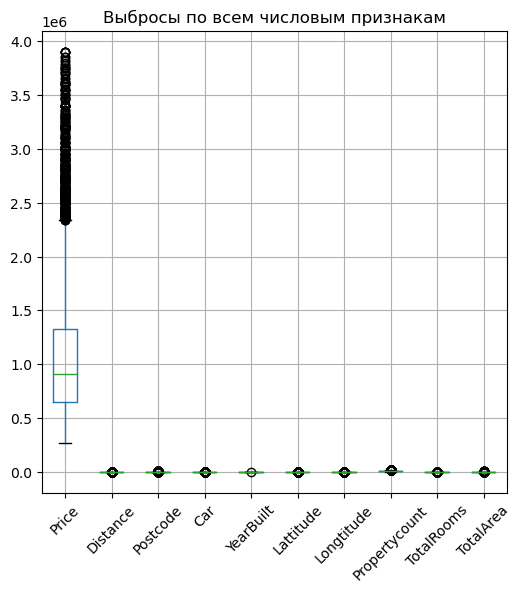

In [57]:
plt.figure(figsize=(6, 6))
X_train[numeric_cols].boxplot()
plt.title('Выбросы по всем числовым признакам')
plt.xticks(rotation=45)
plt.show()

В цене все еще очень много выбросов

# 4. Заполнение пропущенных значений

Посмотрим сколько пропущенных значений в каждом столбце матрицы

In [58]:
X_train.isna().sum()

Suburb              0
Type                0
Price               0
SellerG             0
Date                0
Distance            0
Postcode            0
Car                49
YearBuilt        4223
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
street_type         0
TotalRooms          0
TotalArea        5059
dtype: int64

In [59]:
X_test.isna().sum()

Suburb              0
Type                0
Price               0
SellerG             0
Date                0
Distance            0
Postcode            0
Car                12
YearBuilt        1089
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
street_type         0
TotalRooms          0
TotalArea        1321
dtype: int64

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам.

In [60]:
numeric_cols = X_train.select_dtypes(include=['number']).columns

numeric_medians = X_train[numeric_cols].median()
X_train[numeric_cols] = X_train[numeric_cols].fillna(numeric_medians)
X_test[numeric_cols] = X_test[numeric_cols].fillna(numeric_medians)

In [61]:
X_test.isna().sum()

Suburb           0
Type             0
Price            0
SellerG          0
Date             0
Distance         0
Postcode         0
Car              0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
street_type      0
TotalRooms       0
TotalArea        0
dtype: int64

# 5. Обработка категориальных признаков

Закодируем теперь категориальные признаки. Применим one-hot-encoding

In [62]:
from sklearn.preprocessing import OneHotEncoder

In [63]:
categorical_columns = X_train.select_dtypes(include=['category']).columns.tolist()

ohe = OneHotEncoder(
    handle_unknown='ignore',  
    sparse_output=False)

ohe.fit(X_train[categorical_columns])

X_train_cat_ohe = ohe.transform(X_train[categorical_columns])
X_test_cat_ohe = ohe.transform(X_test[categorical_columns])

ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

X_train_cat_df = pd.DataFrame(X_train_cat_ohe, columns=ohe_feature_names, index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_cat_ohe, columns=ohe_feature_names, index=X_test.index)

numerical_columns = [col for col in X_train.columns if col not in categorical_columns]

X_train = pd.concat([X_train[numerical_columns], X_train_cat_df], axis=1)
X_test = pd.concat([X_test[numerical_columns], X_test_cat_df], axis=1)

# 6. Нормализация данных 

Дату переведем в количество дней от минимальной в обучающей выборке даты

In [64]:
min_date = X_train['Date'].min()

X_train['DaysSinceStart'] = (X_train['Date'] - min_date).dt.days
X_test['DaysSinceStart'] = (X_test['Date'] - min_date).dt.days

X_train = X_train.drop('Date', axis=1)
X_test = X_test.drop('Date', axis=1)

In [65]:
from sklearn.preprocessing import StandardScaler

Обучаем только на трейне, применяем ко всем данным

In [66]:
numerical_columns = ['Postcode','TotalRooms', 'Distance', 'Car',
                     'TotalArea', 'YearBuilt', 'Lattitude', 'Longtitude',
                     'DaysSinceStart', 'Propertycount','Price']

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [67]:
X_train.describe()

,Price,Distance,Postcode,Car,YearBuilt,Lattitude,Longtitude,Propertycount,TotalRooms,TotalArea,...,street_type_Ct,street_type_Dr,street_type_Grove,street_type_La,street_type_Other,street_type_Parade,street_type_Pl,street_type_Rd,street_type_St,DaysSinceStart
count,1.065300e+04,1.065300e+04,1.065300e+04,1.065300e+04,1.065300e+04,1.065300e+04,1.065300e+04,1.065300e+04,1.065300e+04,1.065300e+04,...,10653.000000,10653.000000,10653.000000,10653.000000,10653.000000,10653.000000,10653.000000,10653.000000,10653.000000,1.065300e+04
mean,-2.567905e-17,1.960946e-16,-5.045767e-16,-9.671332e-17,-5.816139e-16,-1.803570e-14,2.050426e-13,4.101979e-17,-2.536223e-16,-2.239414e-16,...,0.045621,0.033699,0.022998,0.005069,0.017741,0.015958,0.011828,0.206515,0.588379,1.350651e-16
std,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,1.000047e+00,...,0.208671,0.180463,0.149905,0.071020,0.132017,0.125319,0.108115,0.404823,0.492150,1.000047e+00
min,-1.365311e+00,-1.724294e+00,-1.146245e+00,-1.678990e+00,-4.840477e+00,-4.717989e+00,-5.408027e+00,-1.534687e+00,-2.388464e+00,-1.638801e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.267699e+00
25%,-7.103263e-01,-6.867901e-01,-6.457265e-01,-6.359973e-01,-2.488464e-01,-5.948803e-01,-6.270438e-01,-7.055254e-01,-1.012427e+00,-1.659066e-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.725628e-01
50%,-2.707971e-01,-1.595341e-01,-2.322544e-01,4.069952e-01,1.043560e-01,8.876689e-02,4.494457e-02,-2.103666e-01,-3.244080e-01,-5.783256e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.077420e-01
75%,4.531334e-01,4.867798e-01,4.532388e-01,4.069952e-01,2.809572e-01,6.611050e-01,6.063744e-01,6.524935e-01,3.636108e-01,4.097799e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.991370e-01
max,4.891517e+00,6.337621e+00,9.484339e+00,8.750935e+00,1.799727e+00,5.061286e+00,5.096373e+00,3.247263e+00,7.931817e+00,1.321675e+01,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.460895e+00


# 7. и 8. Классификатор и подсчет метрик

Возьмем простую линейную модель и модель посильнее, сравним их работу

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

In [72]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.27      0.59      0.37       527
           1       0.86      0.62      0.72      2189

    accuracy                           0.61      2716
   macro avg       0.57      0.60      0.54      2716
weighted avg       0.75      0.61      0.65      2716

ROC-AUC: 0.6531059645302587

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.52      0.08      0.14       527
           1       0.82      0.98      0.89      2189

    accuracy                           0.81      2716
   macro avg       0.67      0.53      0.51      2716
weighted avg       0.76      0.81      0.75      2716

ROC-AUC: 0.6492229129085136


Видим что и простая модель, и посложнее - обучаются слабовато. Сказываются несбалансированность классов 80/20, а также небольшое количество данных (10к) при большом количестве признаков (167).